In [1]:
import os
from fitting import FitModel
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import input_checker as ic
import json
import lammps
import glob
from matplotlib import gridspec
import seaborn as sns

In [2]:
def get_forces(fit_data, values, args):
    fit_data.init_potential(values, args)
    ip_forces = fit_data.get_forces()
    dft_forces = fit_data.expected_forces()
    return dft_forces, ip_forces

def get_lattice(fit_data, values, args):
    fit_data.init_potential(values, args)
    lmp = fit_data.get_lattice_params()
    return lmp

def differences(a_c_vol, ref):
    return ((a_c_vol-ref)/ref)*100

In [3]:
params = {}
params['core_shell'] = { 'Li': False, 'Ni': False, 'O': True }
params['charges'] = {'Li': +1.0,
                     'Ni': +3.0,
                     'O': {'core':  -2.0, #+0.960,
                           'shell': 0.0}} #-2.960}}
params['masses'] = {'Li': 6.941,
                    'Ni': 58.6934,
                    'O': {'core': 14.3991,
                          'shell': 1.5999} }
params['cs_springs'] = {'O-O' : [20.0, 0.0]}

distribution = {}
distribution['Li-O'] = {'bpp' : [663.111, 0.119, 0.0],
                        'sd' : [80, 0.01, 0.01]}
distribution['Ni-O'] = {'bpp' : [1393.540, 0.218, 0.000],
                        'sd'  : [80, 0.01, 0.01]}
distribution['O-O'] = {'bpp' : [25804.807, 0.284, 0.0],
                       'sd'  : [200, 0.01, 5]}

In [4]:
tot_num_structures = 1 #Total number of structures in the pool
head_directory_name = '3_structure_fits'
poscar_directory = os.path.join('poscars','thermos')
outcar_directory = os.path.join('outcars','thermos')

In [5]:
##### ref_DFT = [2.729, 14.053, 96.456]
ref_DFT = [10.916, 10.061, 14.053, 1543.293] #(2.7289340495999999*4, (5.0304288864000002*2), 14.053= (14.0527168296999996*1), volume is a*b*c =1543.2928215270413)
ref_DFT = np.array([ref_DFT[0]*2,ref_DFT[1]*2,ref_DFT[2]*2,ref_DFT[3]*8])

calculated_parameters = []
percent_difference = []
for potential_file in sorted(glob.glob('{}/*/potentials.json'.format(head_directory_name))):
    with open(potential_file, 'r') as f:
        potentials = json.load(f)
    for structure in range(tot_num_structures): 
        os.system('cp {}/POSCAR{} {}/POSCAR1'.format(poscar_directory, structure+1, 'poscars'))
        os.system('cp {}/OUTCAR{} {}/OUTCAR1'.format(outcar_directory, structure+1, 'outcars'))
        fit_data = FitModel.collect_info(params, distribution, supercell=[2,2,2])
        lmp = get_lattice(fit_data, potentials.values(), potentials.keys())
        lammps = lmp[0]
        a_c_vol = np.array([lammps.box.lengths[0], lammps.box.lengths[1], lammps.box.lengths[2], lammps.box.volume])
        calculated_parameters.append(a_c_vol)
        diffs = differences(a_c_vol, ref_DFT)
        percent_difference.append(diffs)
#         print(a_c_vol)
#         print(diffs)

Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements

In [6]:
calculated_parameters = np.array(calculated_parameters)
percent_difference = np.array(percent_difference)

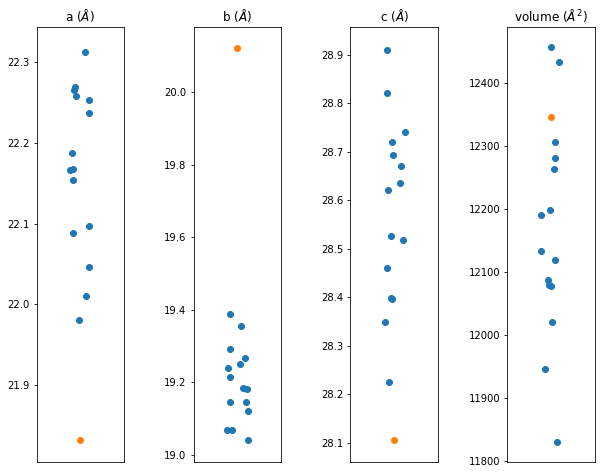

In [23]:
labels = ['a ($\AA$)', 'b ($\AA$)', 'c ($\AA$)', 'volume ($\AA^2$)']
fig, axs = plt.subplots(1, len(labels), figsize=(10,8))
plt.subplots_adjust(wspace=0.8)
for i, label in enumerate(labels):
    x = np.random.rand(len(calculated_parameters))
    axs[i].scatter(x, calculated_parameters.transpose()[i])
    axs[i].scatter(0.5, ref_DFT[i])
    axs[i].set_xlim(left=-1.5, right=2.5)
    axs[i].set_xticks([])
    axs[i].set_title('{}'.format(label))
plt.savefig('plots/3_structure_lattice_comparison.png',dpi=500, bbox_inches = "tight")
plt.show()

In [19]:
np.savetxt('3_structure_lattice_values.dat', calculated_parameters, header = ' '.join(labels))
np.savetxt('3_structure_lattice_diffs.dat', percent_difference, header = ' '.join(labels))

In [16]:
def scatter_plot(x,y,ref_DFT,label,gs):
    axs = plt.subplot(gs)
    axs.scatter(x, y)
    axs.scatter(0.5, ref_DFT)
    axs.set_xlim(left=-1.5, right=2.5)
    axs.set_xticks([])
    axs.set_title('{}'.format(label))
    plt.subplots_adjust(wspace=0)
    return axs

def distribution_plot(df_data, gs):
    axs = plt.subplot(gs)
    axs.axis('off')
    axs = sns.kdeplot(y, vertical=True, shade=True)
    return axs

def y_limits(ref_DFT, y):
    if ref_DFT <= y.min():
        ylims = (ref_DFT-(ref_DFT*0.002), y.max()+(y.max()*0.002))
    elif ref_DFT >= y.max():
        ylims = (y.min()-(y.min()*0.002), ref_DFT+(ref_DFT*0.002))
    else:
        ylims = (y.min()-(y.min()*0.002), y.max()+(y.max()*0.002))
    return ylims

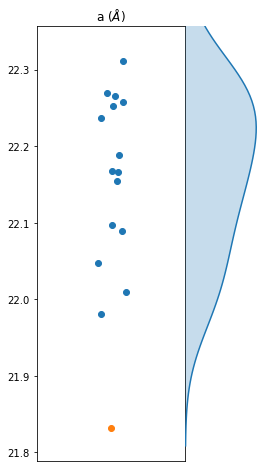

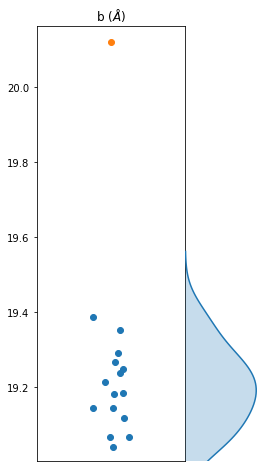

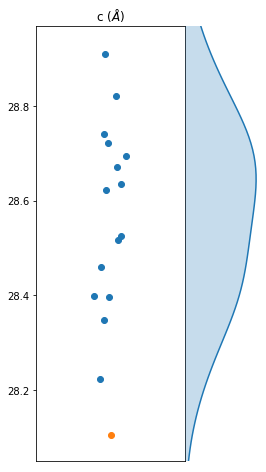

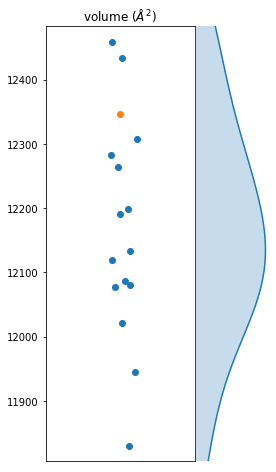

In [24]:
labels = ['a ($\AA$)', 'b ($\AA$)', 'c ($\AA$)', 'volume ($\AA^2$)']
short_labels = ['a', 'b', 'c', 'volume']

for i in range(len(labels)):
    fig, axs = plt.subplots(1, 2, figsize=(4,8), sharey=True)
    plt.subplots_adjust(wspace=0)
    x = np.random.rand(len(calculated_parameters))
    y = calculated_parameters.T[i]
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

    axs[0] = scatter_plot(x,y,ref_DFT[i],labels[i],gs[0])
    axs[1] = distribution_plot(y, gs[1])
    ylims = y_limits(ref_DFT[i], y)
    axs[0].set_ylim(ylims)
    axs[1].set(ylim =ylims)
    plt.savefig('plots/3_structure_lattice_comparison_{}.png'.format(short_labels[i]),dpi=500, bbox_inches = "tight")
    plt.show()


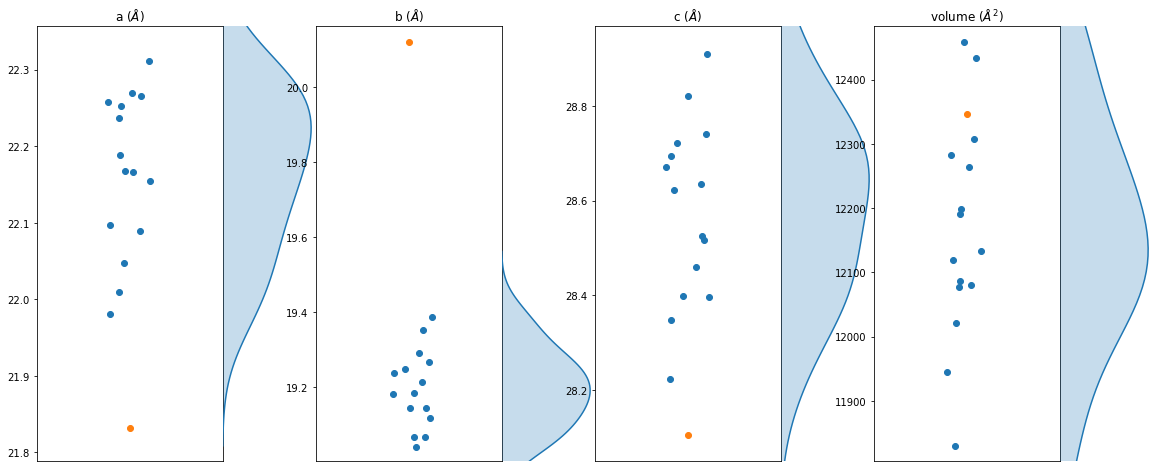

In [18]:
labels = ['a ($\AA$)', 'b ($\AA$)', 'c ($\AA$)', 'volume ($\AA^2$)']
fig, axs = plt.subplots(1, 8, figsize=(20,8), sharey=True)
plt.subplots_adjust(wspace=0.0)
gs = gridspec.GridSpec(1, 8, width_ratios=[1, 0.5, 1, 0.5, 1, 0.5, 1, 0.5])

for i, j in enumerate(range(0,8,2)):
    y = calculated_parameters.T[i]
    x = np.random.rand(len(y))
    ylims = y_limits(ref_DFT[i], y)  
    axs[j] = scatter_plot(x,y,ref_DFT[i],labels[i],gs[j])
    axs[j+1] = distribution_plot(y, gs[j+1])
    ylims = y_limits(ref_DFT[i], y)
    axs[j].set_ylim(ylims)
    axs[j+1].set(ylim =ylims)
#     plt.savefig('plots/3_structure_lattice_comparison.png',dpi=500, bbox_inches = "tight")
plt.show()

In [ ]:
# plt.plot([1,0.9,0.8,0.7,0.6,0.5,0.4, 0.3, 0.2, 0.1],[1.91447, 1.15191, 0.64100, 0.3006, 0.16467, 0.10002, 0.09871, 0.12966, 0.16898, 0.19944], '-ok')
# plt.xlabel('charge scaling factor')
# plt.ylabel('MSE')
# plt.savefig('charge_scaling_error_plot.png',dpi=500, bbox_inches = "tight")
# plt.show()

In [22]:
# plt.plot([1, 2, 3, 4, 5, 6, 7, 8],[0.25289, 0.27519, 0.28708, 0.29331, 0.30346, 0.30094, 0.30782, 0.30310], '-ok')
# plt.xlabel('number of structures')
# plt.ylabel('fit error')
# plt.savefig('error_vs_numStructure.png',dpi=500, bbox_inches = "tight")
# plt.show()

In [ ]:
# Geometry optimised structure:
#      fun: 0.00024535877391032265
#        x: array([6.63110880e+02, 1.19385635e-01, 1.39354000e+03, 2.17550689e-01,
#        2.58048072e+04, 2.84121273e-01])

In [ ]:
#      fun: 0.00020117218726958615
#        x: array([5.16859856e+02, 2.27622770e-01, 3.17959194e+02, 3.02641291e-01,
#        1.56010420e+04, 3.00961159e-01])

In [ ]:
#      fun: 2.9965469134567404e-05
#        x: array([1.57187515e+03, 2.38087128e-01, 2.18242730e+02, 5.40287127e-01,
#        3.67954544e+04, 3.99826009e-02])

In [ ]:
#      fun: 0.00022146538630216886
#        x: array([1.99884762e+03, 1.97915567e-01, 1.92779928e+03, 2.00805359e-01,
#        2.23406599e+04, 2.91794009e-01])

In [ ]:
#      fun: 0.00021587433861985865
#        x: array([1.36449374e+03, 2.07769552e-01, 5.85016576e+02, 2.44567736e-01,
#        2.12183128e+04, 2.92891694e-01])

In [ ]:
#      fun: 0.0001749872704503645
#        x: array([1.27061887e+03, 2.08855364e-01, 3.21011122e+02, 3.30160472e-01,
#        8.15204948e+03, 3.24710512e-01])

In [ ]:
#      fun: 0.00024201340356503294
#        x: array([1.51933430e+03, 2.19804987e-01, 2.73284257e+03, 1.25871870e-01,
#        3.99602258e+04, 2.74290327e-01])

In [ ]:
#      fun: 3.0152162973553667e-05
#        x: array([1.61227502e+03, 2.36678924e-01, 2.18410497e+02, 5.39111493e-01,
#        1.18954090e+02, 2.72658396e-01])

In [ ]:
#      fun: 0.00020736598495354775
#        x: array([1.83446063e+03, 1.86905880e-01, 2.72859123e+02, 3.07100959e-01,
#        2.00429777e+04, 2.91059506e-01])